<a href="https://colab.research.google.com/github/techn-0/Digital_Imaging/blob/main/rotation_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 각도 증강 (Rotation Augmentation) 프로젝트
## Albumentations + OpenCV를 활용한 회전 변환

**목표**: 원본 이미지를 1000장으로 각도 증강
- 증강 방법: 회전 변환 (Rotation)
- 증강 단계: 1000단계의 회전 각도

**사용 라이브러리**:
- Albumentations: 고성능 이미지 증강
- OpenCV: 기본 이미지 처리 및 알고리즘 원리

## 1. 라이브러리 설치 및 임포트

In [1]:
# 필요한 라이브러리 설치
!pip install albumentations opencv-python-headless matplotlib numpy pillow

In [2]:
import albumentations as A
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os
from google.colab import files
from PIL import Image
import zipfile
from tqdm import tqdm
import math

print(f"Albumentations 버전: {A.__version__}")
print(f"OpenCV 버전: {cv2.__version__}")

Albumentations 버전: 2.0.8
OpenCV 버전: 4.12.0


## 2. 디렉토리 설정 및 이미지 업로드

In [3]:
# 디렉토리 생성
os.makedirs('original_images', exist_ok=True)
os.makedirs('rotation_augmented', exist_ok=True)
os.makedirs('rotation_results', exist_ok=True)

print("디렉토리 생성 완료")
print("- original_images: 원본 이미지 저장")
print("- rotation_augmented: 회전 증강된 이미지 저장")
print("- rotation_results: 분석 결과 저장")

디렉토리 생성 완료
- original_images: 원본 이미지 저장
- rotation_augmented: 회전 증강된 이미지 저장
- rotation_results: 분석 결과 저장


In [4]:
# 이미지 업로드
print("원본 이미지를 업로드해주세요...")
uploaded = files.upload()

# 업로드된 파일을 original_images 폴더로 이동
for filename in uploaded.keys():
    os.rename(filename, f'original_images/{filename}')
    print(f"✓ {filename} 저장 완료")

# 원본 이미지 목록 확인
original_images = list(Path('original_images').glob('*'))
original_images = [str(img) for img in original_images if img.suffix.lower() in ['.jpg', '.jpeg', '.png', '.bmp']]

print(f"\n총 {len(original_images)}개의 원본 이미지가 준비되었습니다.")

원본 이미지를 업로드해주세요...


Saving wa.jpg to wa.jpg
Saving watashi.jpg to watashi.jpg
✓ wa.jpg 저장 완료
✓ watashi.jpg 저장 완료

총 2개의 원본 이미지가 준비되었습니다.


## 3. 회전 증강 파라미터 설정

### 목표: 1000장 생성
- 회전 각도: 1000단계
- 범위: -180도 ~ +180도 (전체 360도 회전)
- 간격: 0.36도씩 증가 (1000단계)

In [5]:
# 회전 증강 파라미터 정의
ROTATION_ANGLES = np.linspace(-180, 180, 1000)  # 1000단계
TARGET_COUNT = 1000

print(f"회전 각도 단계: {len(ROTATION_ANGLES)}개")
print(f"각도 범위: {ROTATION_ANGLES[0]:.2f}도 ~ {ROTATION_ANGLES[-1]:.2f}도")
print(f"각도 간격: {ROTATION_ANGLES[1] - ROTATION_ANGLES[0]:.4f}도")
print(f"\n총 생성될 이미지: {len(ROTATION_ANGLES)}장")

# 샘플 각도 값 출력
print(f"\n[샘플 회전 각도]")
print(f"  -180도: {ROTATION_ANGLES[0]:.2f}도")
print(f"  -90도: {ROTATION_ANGLES[249]:.2f}도")
print(f"  0도: {ROTATION_ANGLES[499]:.2f}도")
print(f"  +90도: {ROTATION_ANGLES[749]:.2f}도")
print(f"  +180도: {ROTATION_ANGLES[999]:.2f}도")

회전 각도 단계: 1000개
각도 범위: -180.00도 ~ 180.00도
각도 간격: 0.3604도

총 생성될 이미지: 1000장

[샘플 회전 각도]
  -180도: -180.00도
  -90도: -90.27도
  0도: -0.18도
  +90도: 89.91도
  +180도: 180.00도


## 4. 회전 변환 알고리즘

### 수학적 원리

회전 변환은 2D Affine Transformation을 사용하여 수행됩니다:

#### 회전 행렬 (Rotation Matrix)
$$
M = \begin{bmatrix}
\cos(\theta) & -\sin(\theta) & t_x \\
\sin(\theta) & \cos(\theta) & t_y
\end{bmatrix}
$$

여기서:
- $\theta$: 회전 각도 (라디안)
- $(t_x, t_y)$: 이동 벡터 (이미지 중심 기준 회전을 위함)

#### 좌표 변환
$$
\begin{bmatrix} x' \\ y' \end{bmatrix} =
\begin{bmatrix}
\cos(\theta) & -\sin(\theta) \\
\sin(\theta) & \cos(\theta)
\end{bmatrix}
\begin{bmatrix} x \\ y \end{bmatrix}
$$

### 구현 방법
1. **Albumentations**: Rotate 함수 사용
2. **OpenCV**: getRotationMatrix2D + warpAffine 함수 사용

In [6]:
def augment_rotation_albumentations(image, rotation_angle):
    """
    Albumentations를 사용한 회전 증강

    Args:
        image: 입력 이미지 (numpy array, RGB)
        rotation_angle: 회전 각도 (-180~180)

    Returns:
        augmented_image: 회전된 이미지
    """
    # Albumentations transform 정의
    transform = A.Compose([
        A.Rotate(
            limit=(rotation_angle, rotation_angle),  # 정확한 각도로 회전
            border_mode=cv2.BORDER_CONSTANT,  # 빈 공간을 상수값으로 채움
            value=0,  # 검은색으로 채움
            p=1.0  # 항상 적용
        ),
    ])

    # 증강 적용
    augmented = transform(image=image)
    return augmented['image']


def augment_rotation_opencv(image, rotation_angle):
    """
    OpenCV를 사용한 회전 증강

    Args:
        image: 입력 이미지 (numpy array, RGB)
        rotation_angle: 회전 각도

    Returns:
        augmented_image: 회전된 이미지
    """
    height, width = image.shape[:2]
    center = (width // 2, height // 2)  # 회전 중심점

    # 회전 행렬 계산
    # getRotationMatrix2D(center, angle, scale)
    # 내부적으로 cos(θ), sin(θ) 계산하여 2x3 변환 행렬 생성
    rotation_matrix = cv2.getRotationMatrix2D(center, rotation_angle, scale=1.0)

    # 회전 적용 (Affine Transformation)
    rotated = cv2.warpAffine(
        image,
        rotation_matrix,
        (width, height),
        borderMode=cv2.BORDER_CONSTANT,
        borderValue=(0, 0, 0)
    )

    return rotated

print("✓ 회전 증강 함수 정의 완료")

✓ 회전 증강 함수 정의 완료


## 5. 알고리즘 비교 및 샘플 생성

/tmp/ipython-input-1897906804.py:14: UserWarning: Argument(s) 'value' are not valid for transform Rotate
  A.Rotate(
/tmp/ipython-input-3430540712.py:36: UserWarning: Glyph 54924 (\N{HANGUL SYLLABLE HOE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3430540712.py:36: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3430540712.py:36: UserWarning: Glyph 48320 (\N{HANGUL SYLLABLE BYEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3430540712.py:36: UserWarning: Glyph 54872 (\N{HANGUL SYLLABLE HWAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3430540712.py:36: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3430540712.py:36: UserWarning: Glyph 44368 (\N{HANGUL SYLLABLE GYO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-343

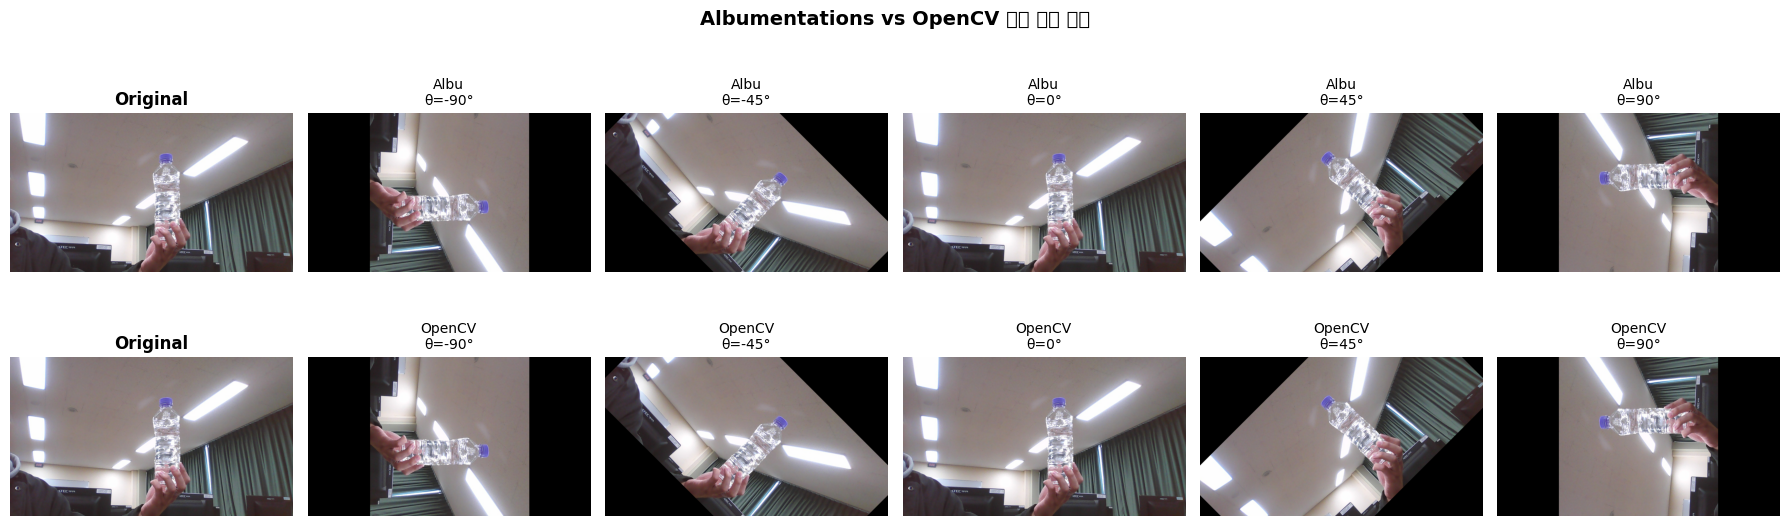

✓ 알고리즘 비교 이미지 저장: rotation_results/algorithm_comparison.png


In [7]:
# 첫 번째 원본 이미지로 샘플 생성
if len(original_images) > 0:
    sample_image_path = original_images[0]
    sample_image = cv2.imread(sample_image_path)
    sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)

    # 5가지 다른 각도로 테스트
    test_angles = [-90, -45, 0, 45, 90]

    # Albumentations 결과
    fig, axes = plt.subplots(2, 6, figsize=(18, 6))

    # 첫 번째 행: Albumentations
    axes[0, 0].imshow(sample_image)
    axes[0, 0].set_title('Original', fontweight='bold')
    axes[0, 0].axis('off')

    for idx, angle in enumerate(test_angles, 1):
        aug_img = augment_rotation_albumentations(sample_image, angle)
        axes[0, idx].imshow(aug_img)
        axes[0, idx].set_title(f'Albu\nθ={angle}°', fontsize=10)
        axes[0, idx].axis('off')

    # 두 번째 행: OpenCV
    axes[1, 0].imshow(sample_image)
    axes[1, 0].set_title('Original', fontweight='bold')
    axes[1, 0].axis('off')

    for idx, angle in enumerate(test_angles, 1):
        aug_img = augment_rotation_opencv(sample_image, angle)
        axes[1, idx].imshow(aug_img)
        axes[1, idx].set_title(f'OpenCV\nθ={angle}°', fontsize=10)
        axes[1, idx].axis('off')

    plt.suptitle('Albumentations vs OpenCV 회전 변환 비교', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('rotation_results/algorithm_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()

    print("✓ 알고리즘 비교 이미지 저장: rotation_results/algorithm_comparison.png")
else:
    print("⚠ 원본 이미지를 먼저 업로드해주세요.")

## 6. 회전 각도별 샘플 시각화

/tmp/ipython-input-1897906804.py:14: UserWarning: Argument(s) 'value' are not valid for transform Rotate
  A.Rotate(
/tmp/ipython-input-2864411635.py:16: UserWarning: Glyph 54924 (\N{HANGUL SYLLABLE HOE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2864411635.py:16: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2864411635.py:16: UserWarning: Glyph 44033 (\N{HANGUL SYLLABLE GAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2864411635.py:16: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2864411635.py:16: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2864411635.py:16: UserWarning: Glyph 51613 (\N{HANGUL SYLLABLE JEUNG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-28

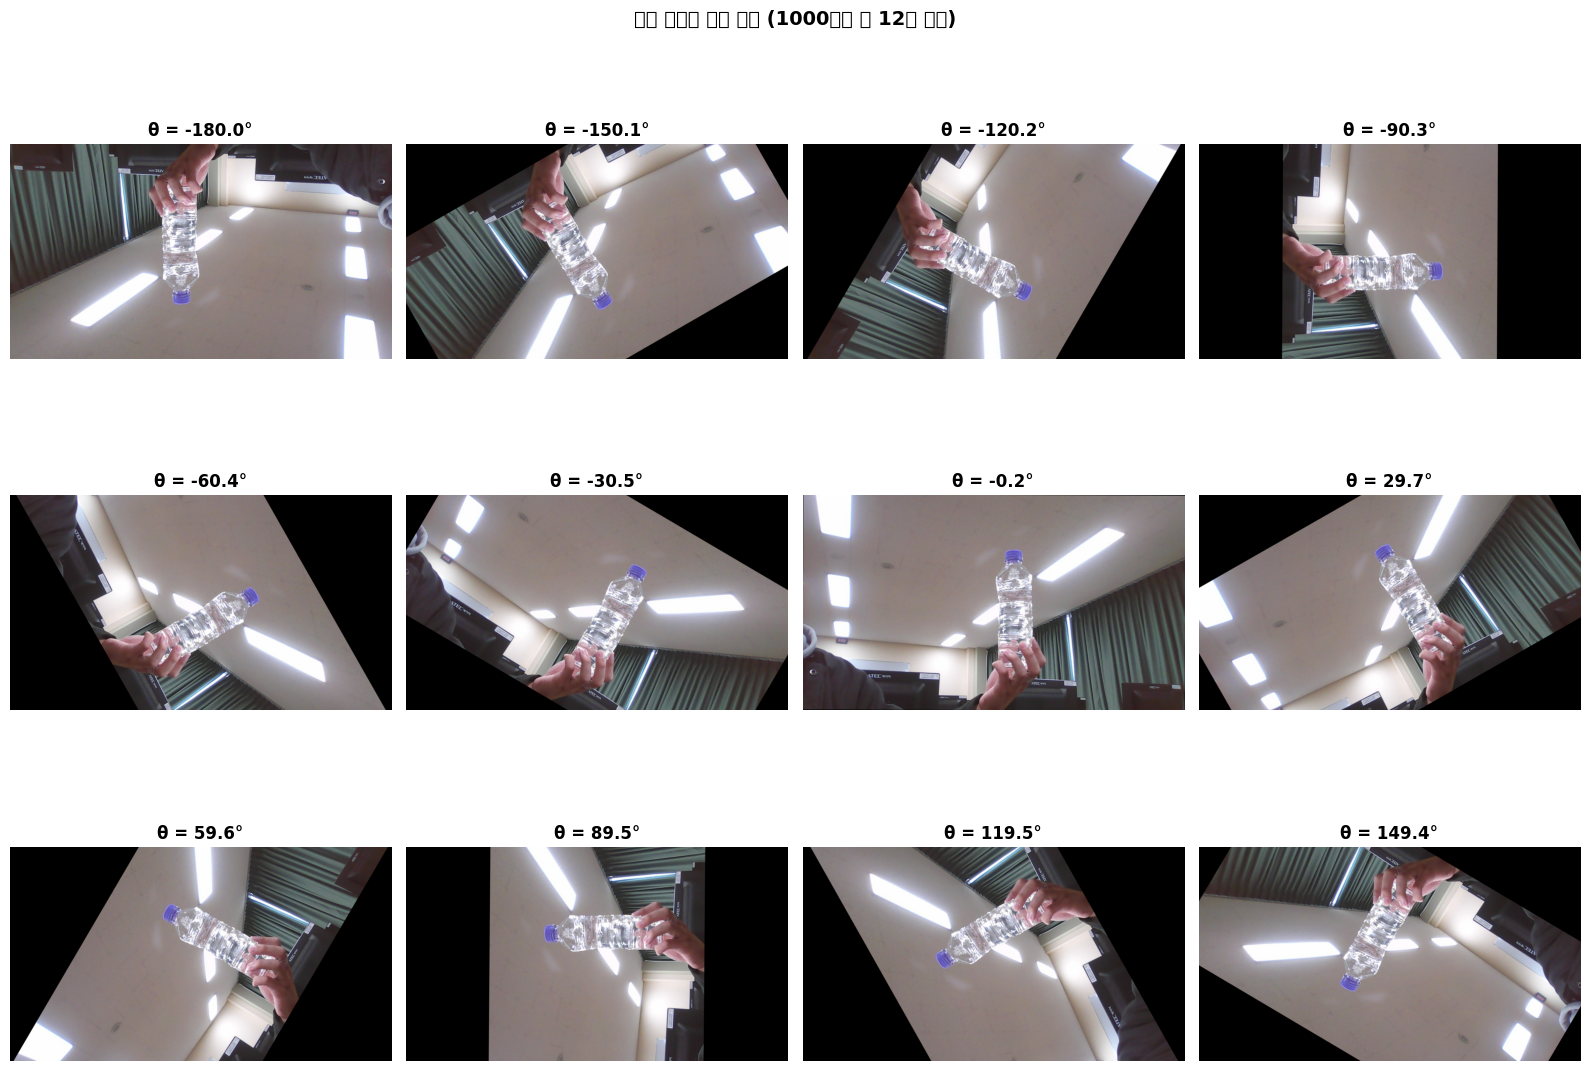

✓ 회전 샘플 이미지 저장: rotation_results/rotation_samples.png


In [8]:
# 1000단계 중 대표적인 12단계 선택
if len(original_images) > 0:
    sample_indices = [0, 83, 166, 249, 332, 415, 499, 582, 665, 748, 831, 914]
    sample_angles = ROTATION_ANGLES[sample_indices]

    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    axes = axes.flatten()

    for idx, angle in enumerate(sample_angles):
        aug_img = augment_rotation_albumentations(sample_image, angle)
        axes[idx].imshow(aug_img)
        axes[idx].set_title(f'θ = {angle:.1f}°', fontsize=12, fontweight='bold')
        axes[idx].axis('off')

    plt.suptitle('회전 각도별 증강 결과 (1000단계 중 12개 샘플)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('rotation_results/rotation_samples.png', dpi=150, bbox_inches='tight')
    plt.show()

    print("✓ 회전 샘플 이미지 저장: rotation_results/rotation_samples.png")

## 7. 회전 행렬 시각화

/tmp/ipython-input-1897906804.py:14: UserWarning: Argument(s) 'value' are not valid for transform Rotate
  A.Rotate(
/tmp/ipython-input-3283737749.py:28: UserWarning: Glyph 54924 (\N{HANGUL SYLLABLE HOE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3283737749.py:28: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3283737749.py:28: UserWarning: Glyph 44033 (\N{HANGUL SYLLABLE GAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3283737749.py:28: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3283737749.py:28: UserWarning: Glyph 50752 (\N{HANGUL SYLLABLE WA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3283737749.py:28: UserWarning: Glyph 48320 (\N{HANGUL SYLLABLE BYEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-32837

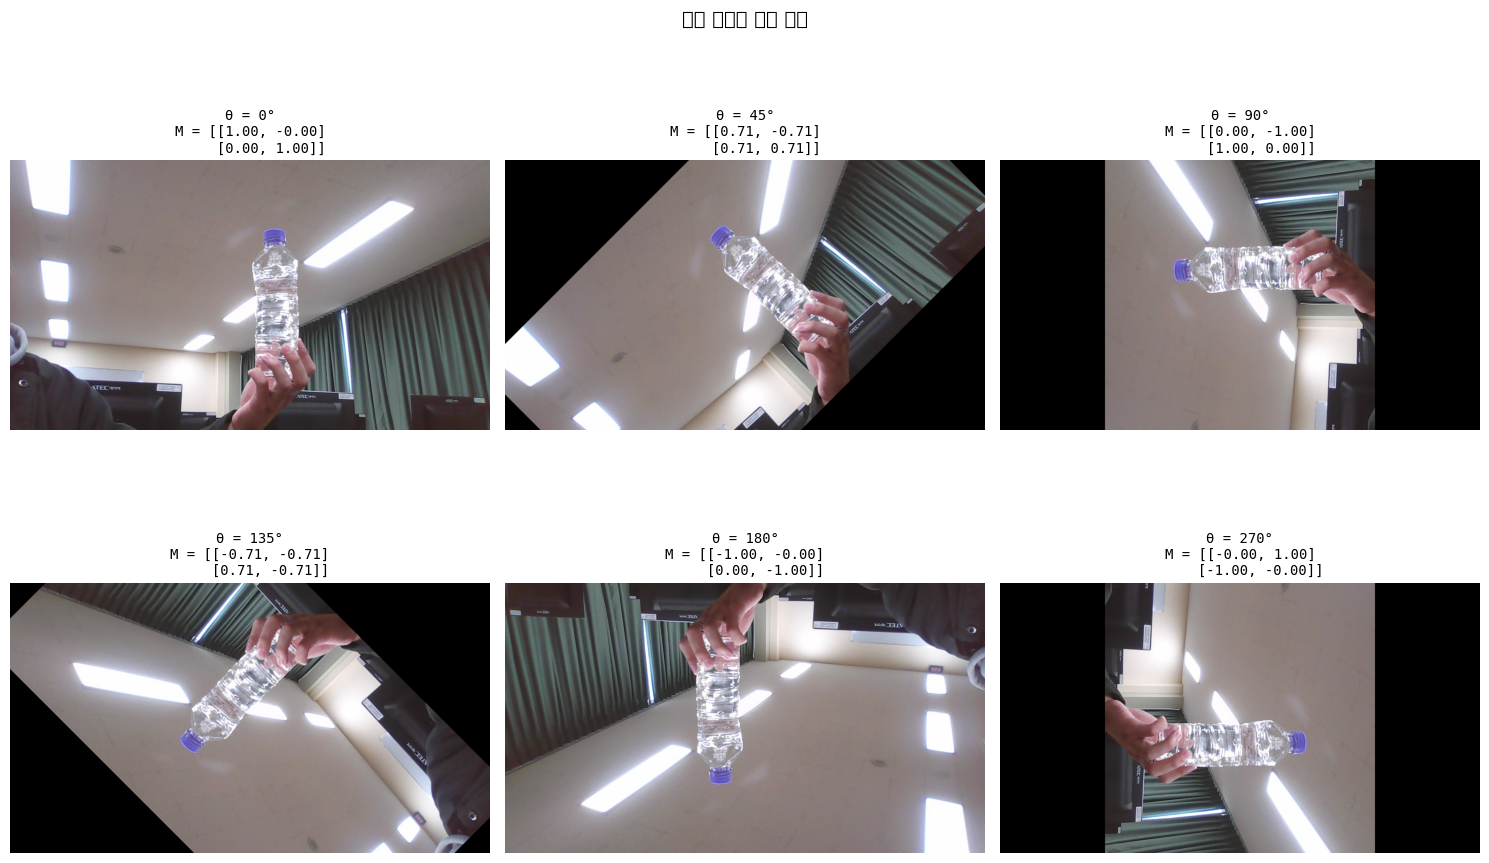

✓ 회전 행렬 시각화 저장: rotation_results/rotation_matrices.png


In [9]:
# 회전 행렬의 수학적 원리 시각화
if len(original_images) > 0:
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    test_angles = [0, 45, 90, 135, 180, 270]

    for idx, angle in enumerate(test_angles):
        ax = axes[idx // 3, idx % 3]

        # 이미지 회전
        rotated = augment_rotation_albumentations(sample_image, angle)
        ax.imshow(rotated)

        # 회전 행렬 계산
        theta_rad = math.radians(angle)
        cos_theta = math.cos(theta_rad)
        sin_theta = math.sin(theta_rad)

        # 타이틀에 회전 행렬 정보 표시
        title = f'θ = {angle}°\n'
        title += f'M = [[{cos_theta:.2f}, {-sin_theta:.2f}]\n'
        title += f'     [{sin_theta:.2f}, {cos_theta:.2f}]]'

        ax.set_title(title, fontsize=10, family='monospace')
        ax.axis('off')

    plt.suptitle('회전 각도와 변환 행렬', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('rotation_results/rotation_matrices.png', dpi=150, bbox_inches='tight')
    plt.show()

    print("✓ 회전 행렬 시각화 저장: rotation_results/rotation_matrices.png")

## 8. 전체 이미지 회전 증강 수행 (1000장 생성)

In [10]:
def perform_rotation_augmentation(image_paths, output_dir, method='albumentations'):
    """
    전체 이미지 회전 증강 수행

    Args:
        image_paths: 원본 이미지 경로 리스트
        output_dir: 출력 디렉토리
        method: 'albumentations' 또는 'opencv'
    """
    augment_func = augment_rotation_albumentations if method == 'albumentations' else augment_rotation_opencv

    total_augmentations = 0
    images_per_original = len(ROTATION_ANGLES)

    print(f"\n{'='*70}")
    print(f"회전 증강 시작: {method.upper()} 방식")
    print(f"원본 이미지: {len(image_paths)}개")
    print(f"이미지당 생성 개수: {images_per_original}개")
    print(f"예상 총 생성 개수: {len(image_paths) * images_per_original}개")
    print(f"{'='*70}\n")

    for img_idx, img_path in enumerate(image_paths):
        # 이미지 로드
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        img_name = Path(img_path).stem

        print(f"[{img_idx+1}/{len(image_paths)}] 처리 중: {img_name}")

        # 모든 회전 각도에 대해 증강
        with tqdm(total=images_per_original, desc=f"  회전 증강 진행") as pbar:
            for angle_idx, angle in enumerate(ROTATION_ANGLES):
                # 증강 수행
                augmented = augment_func(image, angle)

                # 파일명 생성: 원본이름_rotation_인덱스.jpg
                output_filename = f"{img_name}_rotate_{angle_idx:04d}_angle{angle:.2f}.jpg"
                output_path = os.path.join(output_dir, output_filename)

                # 저장 (RGB -> BGR 변환)
                cv2.imwrite(output_path, cv2.cvtColor(augmented, cv2.COLOR_RGB2BGR))

                total_augmentations += 1
                pbar.update(1)

        print(f"  ✓ {img_name}: {images_per_original}개 생성 완료\n")

    print(f"\n{'='*70}")
    print(f"회전 증강 완료!")
    print(f"총 생성된 이미지: {total_augmentations}개")
    print(f"저장 위치: {output_dir}")
    print(f"{'='*70}\n")

    return total_augmentations

In [11]:
# Albumentations로 회전 증강 수행
total_count = perform_rotation_augmentation(
    original_images,
    'rotation_augmented',
    method='albumentations'
)


회전 증강 시작: ALBUMENTATIONS 방식
원본 이미지: 2개
이미지당 생성 개수: 1000개
예상 총 생성 개수: 2000개

[1/2] 처리 중: wa


  회전 증강 진행:   0%|          | 0/1000 [00:00<?, ?it/s]/tmp/ipython-input-1897906804.py:14: UserWarning: Argument(s) 'value' are not valid for transform Rotate
  A.Rotate(
  회전 증강 진행: 100%|██████████| 1000/1000 [00:19<00:00, 50.18it/s]


  ✓ wa: 1000개 생성 완료

[2/2] 처리 중: watashi


  회전 증강 진행: 100%|██████████| 1000/1000 [00:17<00:00, 55.76it/s]

  ✓ watashi: 1000개 생성 완료


회전 증강 완료!
총 생성된 이미지: 2000개
저장 위치: rotation_augmented



## 9. 증강 결과 분석 및 통계

총 증강된 이미지 개수: 2000개
목표 달성: ✓ 성공


/tmp/ipython-input-3786191206.py:40: UserWarning: Glyph 54924 (\N{HANGUL SYLLABLE HOE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3786191206.py:40: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3786191206.py:40: UserWarning: Glyph 44033 (\N{HANGUL SYLLABLE GAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3786191206.py:40: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3786191206.py:40: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3786191206.py:40: UserWarning: Glyph 48120 (\N{HANGUL SYLLABLE MI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3786191206.py:40: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tm

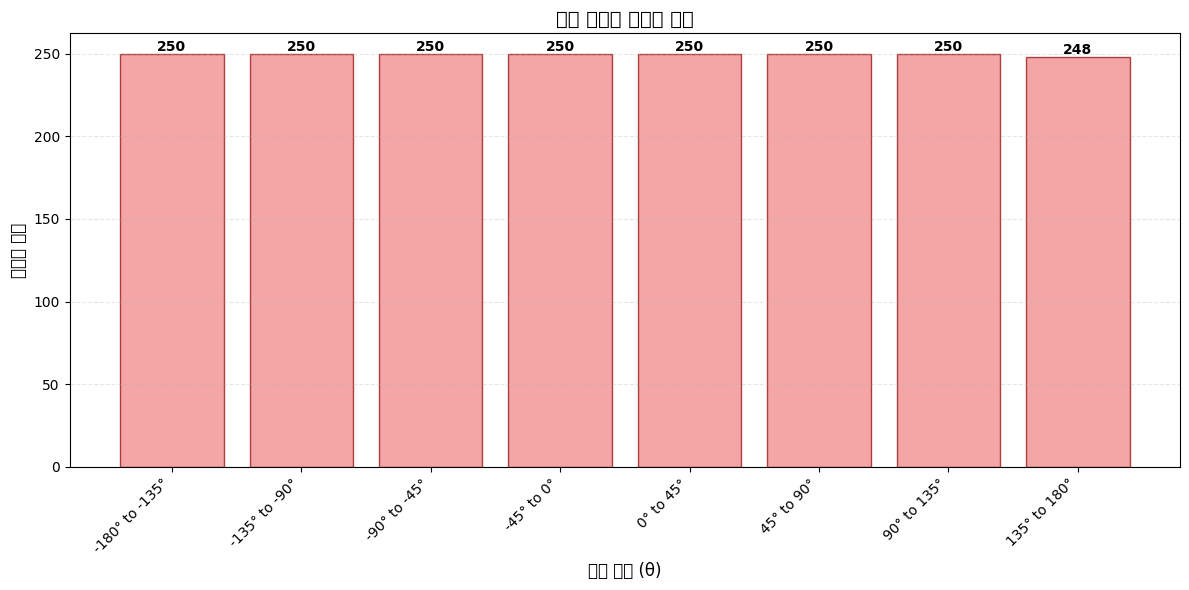

✓ 각도 분포 그래프 저장: rotation_results/angle_distribution.png


In [12]:
# 생성된 이미지 개수 확인
augmented_files = list(Path('rotation_augmented').glob('*.jpg'))
print(f"총 증강된 이미지 개수: {len(augmented_files)}개")
print(f"목표 달성: {'✓ 성공' if len(augmented_files) >= 1000 else '✗ 미달성'}")

# 각도 분포 분석
angle_distribution = np.zeros(8)  # 8개 구간으로 나눔 (45도 간격)
bins = [-180, -135, -90, -45, 0, 45, 90, 135, 180]

for file in augmented_files:
    # 파일명에서 각도 값 추출
    filename = file.stem
    if 'angle' in filename:
        angle_str = filename.split('angle')[1]
        angle_value = float(angle_str)
        # 해당하는 구간 찾기
        for i in range(len(bins)-1):
            if bins[i] <= angle_value < bins[i+1]:
                angle_distribution[i] += 1
                break

# 분포 시각화
fig, ax = plt.subplots(figsize=(12, 6))

bin_labels = [f"{bins[i]}° to {bins[i+1]}°" for i in range(len(bins)-1)]
bars = ax.bar(bin_labels, angle_distribution, color='lightcoral', edgecolor='darkred', alpha=0.7)

# 막대 위에 값 표시
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

ax.set_title('회전 각도별 이미지 분포', fontsize=14, fontweight='bold')
ax.set_xlabel('회전 각도 (θ)', fontsize=12)
ax.set_ylabel('이미지 개수', fontsize=12)
ax.grid(axis='y', alpha=0.3, linestyle='--')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('rotation_results/angle_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ 각도 분포 그래프 저장: rotation_results/angle_distribution.png")

## 10. 360도 회전 애니메이션 시뮬레이션

/tmp/ipython-input-1897906804.py:14: UserWarning: Argument(s) 'value' are not valid for transform Rotate
  A.Rotate(
/tmp/ipython-input-913578559.py:15: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-913578559.py:15: UserWarning: Glyph 54924 (\N{HANGUL SYLLABLE HOE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-913578559.py:15: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-913578559.py:15: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-913578559.py:15: UserWarning: Glyph 53248 (\N{HANGUL SYLLABLE KWEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-913578559.py:15: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-913578559.p

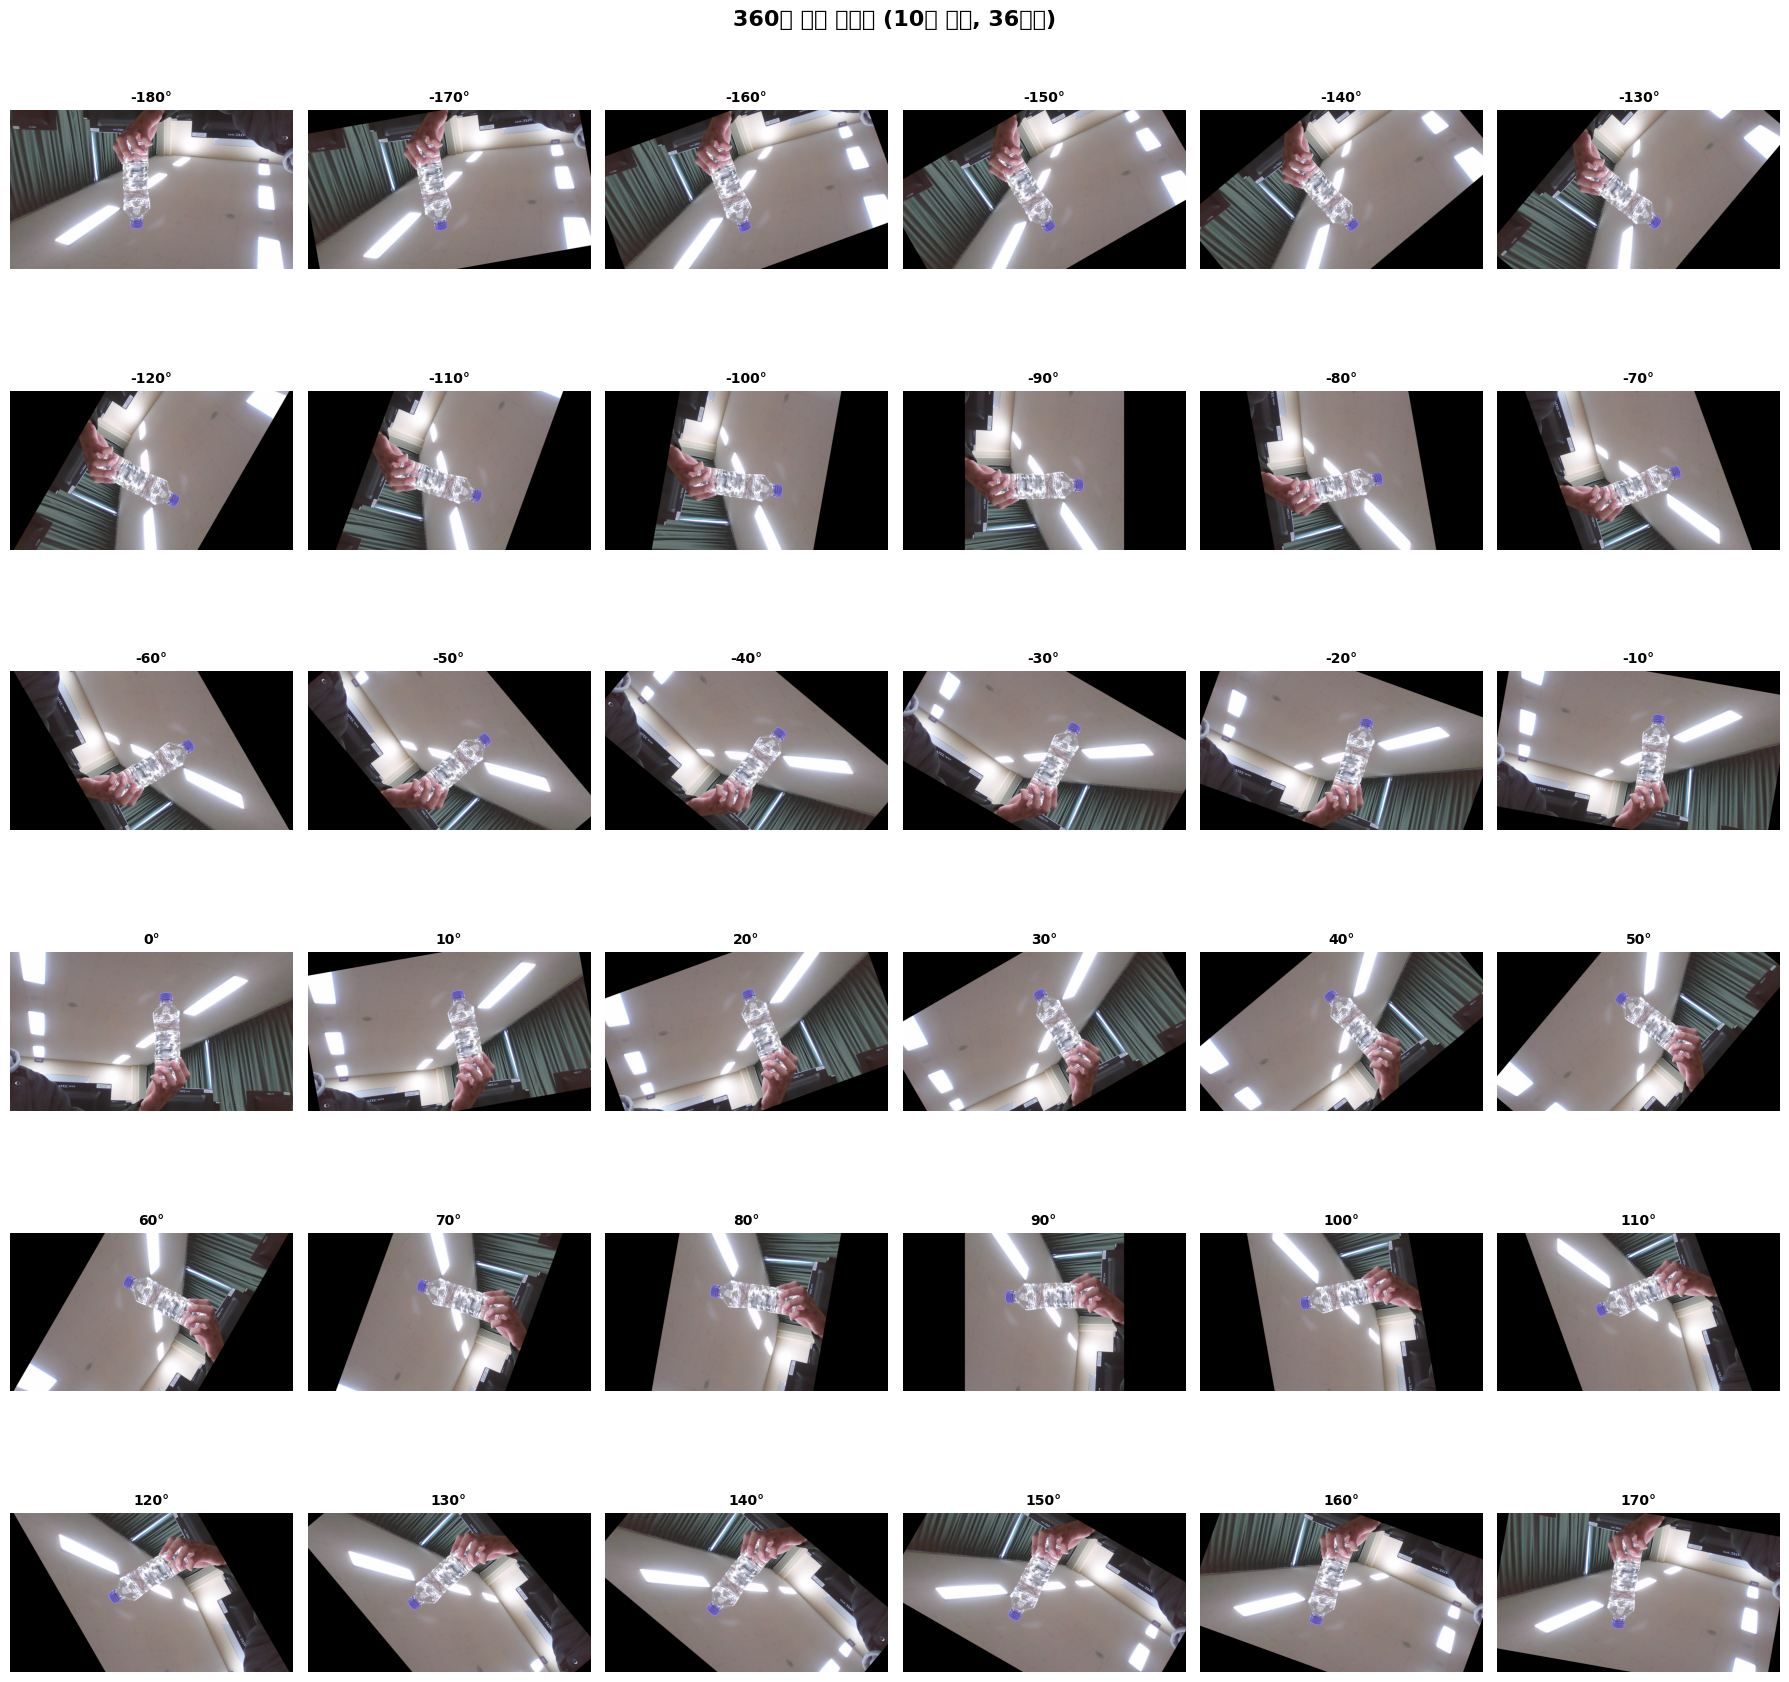

✓ 회전 시퀀스 저장: rotation_results/rotation_sequence.png


In [13]:
# 36단계 (10도 간격) 회전 시퀀스 시각화
if len(original_images) > 0:
    fig, axes = plt.subplots(6, 6, figsize=(18, 18))
    axes = axes.flatten()

    angles_36 = np.linspace(-180, 170, 36)

    for idx, angle in enumerate(angles_36):
        aug_img = augment_rotation_albumentations(sample_image, angle)
        axes[idx].imshow(aug_img)
        axes[idx].set_title(f'{angle:.0f}°', fontsize=10, fontweight='bold')
        axes[idx].axis('off')

    plt.suptitle('360도 회전 시퀀스 (10도 간격, 36단계)', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig('rotation_results/rotation_sequence.png', dpi=150, bbox_inches='tight')
    plt.show()

    print("✓ 회전 시퀀스 저장: rotation_results/rotation_sequence.png")

## 11. 랜덤 샘플 시각화

/tmp/ipython-input-2887913406.py:27: UserWarning: Glyph 54924 (\N{HANGUL SYLLABLE HOE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2887913406.py:27: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2887913406.py:27: UserWarning: Glyph 51613 (\N{HANGUL SYLLABLE JEUNG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2887913406.py:27: UserWarning: Glyph 44053 (\N{HANGUL SYLLABLE GANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2887913406.py:27: UserWarning: Glyph 47004 (\N{HANGUL SYLLABLE RAEN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2887913406.py:27: UserWarning: Glyph 45924 (\N{HANGUL SYLLABLE DEOM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2887913406.py:27: UserWarning: Glyph 49368 (\N{HANGUL SYLLABLE SAEM}) missing from font(s) DejaVu Sans.
  plt.tight_l

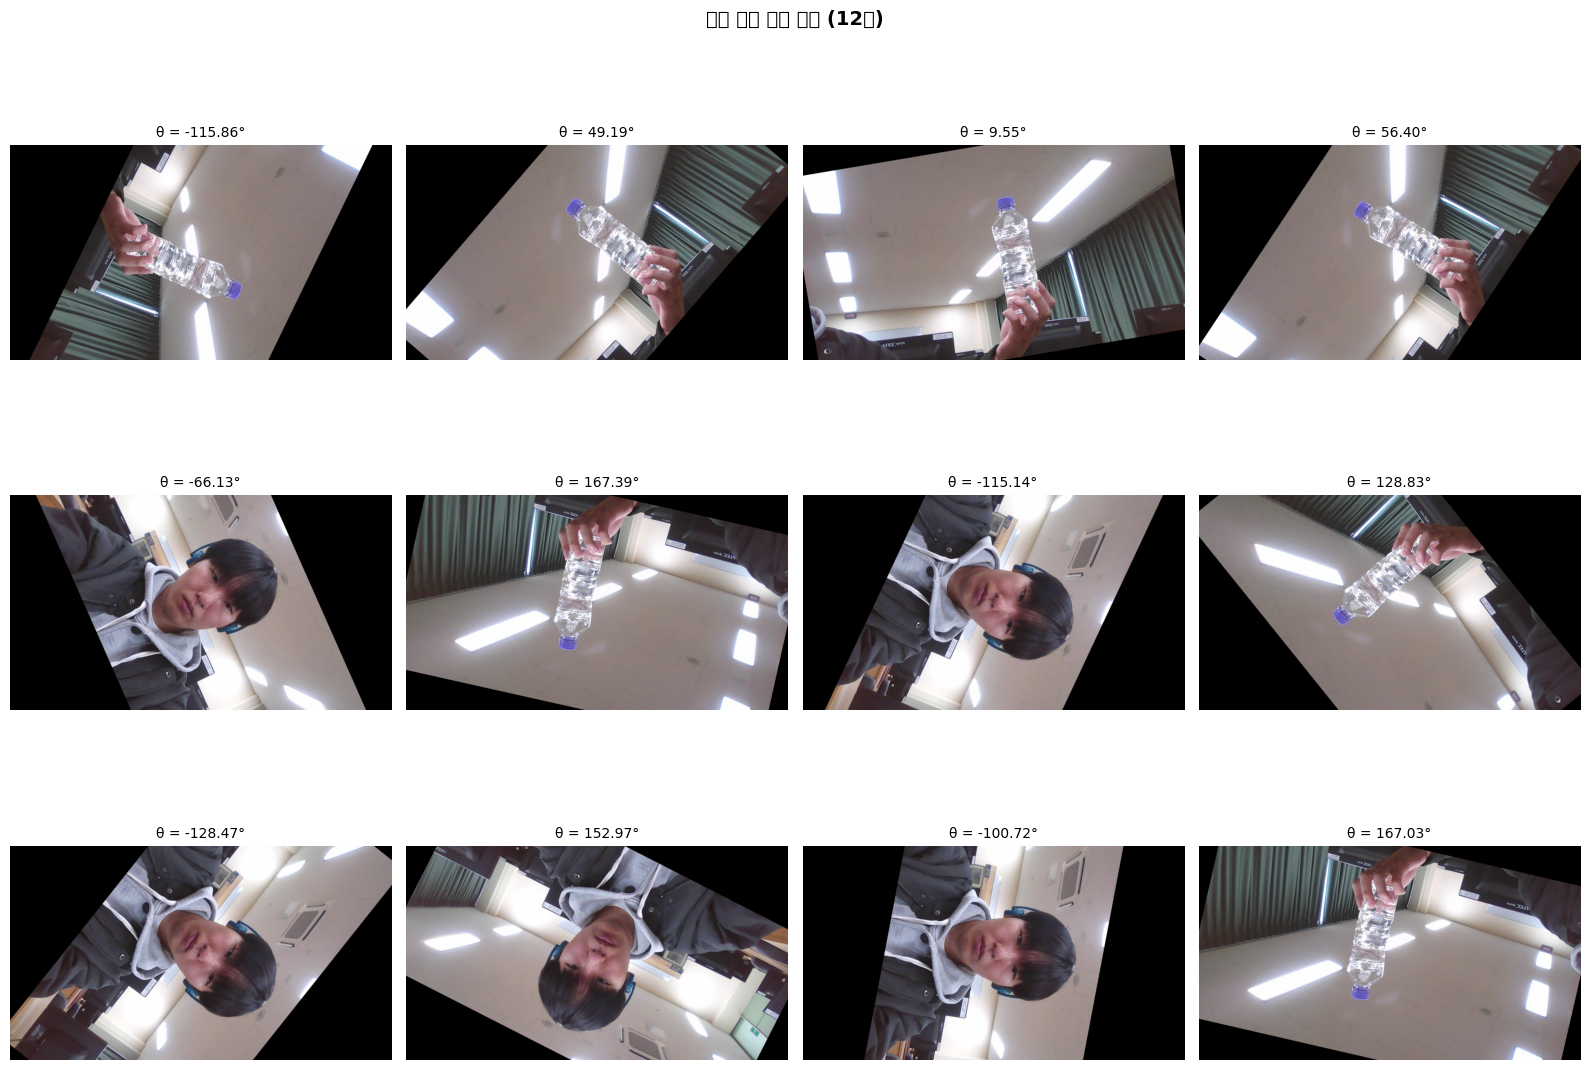

✓ 랜덤 샘플 이미지 저장: rotation_results/random_samples.png


In [14]:
# 랜덤 샘플 시각화
if len(augmented_files) > 0:
    import random
    sample_files = random.sample(augmented_files, min(12, len(augmented_files)))

    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    axes = axes.flatten()

    for idx, img_path in enumerate(sample_files):
        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # 파일명에서 각도 값 추출
        filename = img_path.stem
        if 'angle' in filename:
            angle_str = filename.split('angle')[1]
            angle_value = float(angle_str)
            title = f'θ = {angle_value:.2f}°'
        else:
            title = img_path.name

        axes[idx].imshow(img)
        axes[idx].set_title(title, fontsize=10)
        axes[idx].axis('off')

    plt.suptitle('회전 증강 랜덤 샘플 (12개)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('rotation_results/random_samples.png', dpi=150, bbox_inches='tight')
    plt.show()

    print("✓ 랜덤 샘플 이미지 저장: rotation_results/random_samples.png")

## 12. 결과 다운로드

In [15]:
# 증강된 이미지를 ZIP 파일로 압축
zip_filename = 'rotation_augmented_images.zip'

print("ZIP 파일 생성 중...")
with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for file in tqdm(augmented_files, desc="압축 진행"):
        zipf.write(file, file.name)

print(f"\n✓ ZIP 파일 생성 완료: {zip_filename}")
print(f"파일 크기: {os.path.getsize(zip_filename) / (1024*1024):.2f} MB")

# 다운로드
files.download(zip_filename)
print("\n다운로드가 시작되었습니다!")

ZIP 파일 생성 중...


압축 진행: 100%|██████████| 2000/2000 [00:16<00:00, 120.55it/s]


✓ ZIP 파일 생성 완료: rotation_augmented_images.zip
파일 크기: 305.16 MB


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


다운로드가 시작되었습니다!
